In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the preprocessed data
df_hot = pd.read_csv('Kivela - Final Exam Preprocessed.csv')

In [3]:
## Define Variables
TargetVariable = 'Credit_Mix'

X = df_hot.drop(columns = TargetVariable)
y = df_hot[TargetVariable]

In [4]:
## split the data into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, 
                                                      y, 
                                                      test_size = 0.3, 
                                                      train_size = 0.7, 
                                                      random_state = 373
                                                     )

In [5]:
# Create a tree model with defaults
rf = RandomForestClassifier(random_state=373)

In [6]:
# Fit (train) the model
rf.fit(X = train_X,
        y = train_y,
        #sample_weight=None,
        #check_input=True
       )

RandomForestClassifier(random_state=373)

In [7]:
# Set some names
FeatureNames = list(valid_X.columns)
ClassNames = list(rf.classes_)

In [8]:
# Cross-validation on the training set
cv_scores = cross_val_score(rf, X, y, cv=5)

print("Cross-validation scores on training set:", cv_scores)
print("Mean CV accuracy on training set:", cv_scores.mean())
# Cross Validation accuracy is an estimate of how well the model generalizes to new data.

Cross-validation scores on training set: [0.93867396 0.93133474 0.93655927 0.93357383 0.9302152 ]
Mean CV accuracy on training set: 0.9340714019156613


                          feature  importance       std
17  Payment_of_Min_Amount_Unknown    0.007567  0.045874
13        Amount_invested_monthly    0.010333  0.045874
11       Credit_Utilization_Ratio    0.010580  0.045874
12            Total_EMI_per_month    0.013126  0.045874
14                Monthly_Balance    0.013718  0.045874
1           Monthly_Inhand_Salary    0.014064  0.045874
0                   Annual_Income    0.015601  0.045874
9            Num_Credit_Inquiries    0.019533  0.045874
3                 Num_Credit_Card    0.030066  0.045874
8            Changed_Credit_Limit    0.052357  0.045874
5                     Num_of_Loan    0.057208  0.045874
16     Payment_of_Min_Amount_True    0.081130  0.045874
6             Delay_from_due_date    0.085858  0.045874
15    Payment_of_Min_Amount_False    0.099539  0.045874
2               Num_Bank_Accounts    0.100472  0.045874
7          Num_of_Delayed_Payment    0.110394  0.045874
10               Outstanding_Debt    0.130680  0

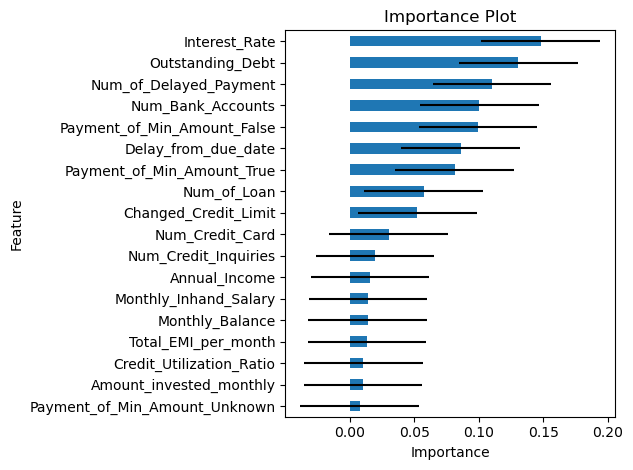

In [9]:
# Feature importance assessment
# shows which features are most influential on the model

## Variable/Feature Importance Plot Data Frame
importances = rf.feature_importances_

# Get standard deviation
std = np.std(importances, 
             axis = 0, 
             dtype=None, 
             out=None, 
             ddof=0, 
             keepdims=False,
             # where=None
             )

# Describe Importances
importance_plot_df = pd.DataFrame({'feature': FeatureNames, 
                                   'importance': importances, 
                                   'std': std})

importance_plot_df = importance_plot_df.sort_values('importance')

print(importance_plot_df)

## Importance Plot
ax = importance_plot_df.plot(kind='barh', 
                             xerr='std', 
                             x='feature', 
                             legend=False)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Importance Plot')
plt.tight_layout()
plt.show()

In [10]:
# Hyperparameter Optimization

# Initial Parameter grid tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_impurity_decrease':[0, 1],
    'min_samples_split': [2, 5, 10]
}

In [11]:
# Try a randomized search instead of gridsearch, cuz it keeps crashing. Need more compute.
rand = RandomizedSearchCV(rf,
                         param_grid,
                         n_iter = 10,
                         cv = 5,
                         scoring = 'accuracy',
                         random_state = 373)

# Fit the randomized cv
rand.fit(X, y)

# Print best parameters and best score
print('Initial score: ', rand.best_score_)
print('Initial parameters: ', rand.best_params_)

Initial score:  0.9369822117178754
Initial parameters:  {'n_estimators': 300, 'min_samples_split': 2, 'min_impurity_decrease': 0, 'max_depth': 15, 'criterion': 'entropy'}


In [12]:
# Updated Parameter grid tuning (wash, rinse, repeat)
param_grid = {
    #'n_estimators': [300],
    'criterion': ['entropy'],
    'max_depth': [15],
    'min_impurity_decrease':[0.00001],
    'min_samples_split': [2]
}

In [13]:
# Cross Validation (Wash, Rinse, Repeat)
rand = RandomizedSearchCV(rf,
                         param_grid,
                         n_iter = 10,
                         cv = 5,
                         scoring = 'accuracy',
                         random_state = 373)

# Fit the randomized cv
rand.fit(X, y)

# Print best parameters and best score
print('Best score: ', rand.best_score_)
print('Best parameters: ', rand.best_params_)

C:\Users\KGLtd\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score:  0.9366090309740016
Best parameters:  {'min_samples_split': 2, 'min_impurity_decrease': 1e-05, 'max_depth': 15, 'criterion': 'entropy'}


In [14]:
# Evaluate the final model on validatoipn data
best_clf = rand.best_estimator_

# Predict on validation data
y_pred = best_clf.predict(valid_X)

# Validation Score
valid_accuracy = best_clf.score(valid_X, valid_y)

print("Accuracy on validation set:", valid_accuracy)

Accuracy on validation set: 0.9834148768554607


Classification Report:
              precision    recall  f1-score   support

         Bad       0.98      1.00      0.99      2819
        Good       0.98      0.98      0.98      3718
    Standard       0.99      0.98      0.98      5522

    accuracy                           0.98     12059
   macro avg       0.98      0.99      0.98     12059
weighted avg       0.98      0.98      0.98     12059

Confusion Matrix:
[[2811    0    8]
 [   0 3645   73]
 [  50   69 5403]]


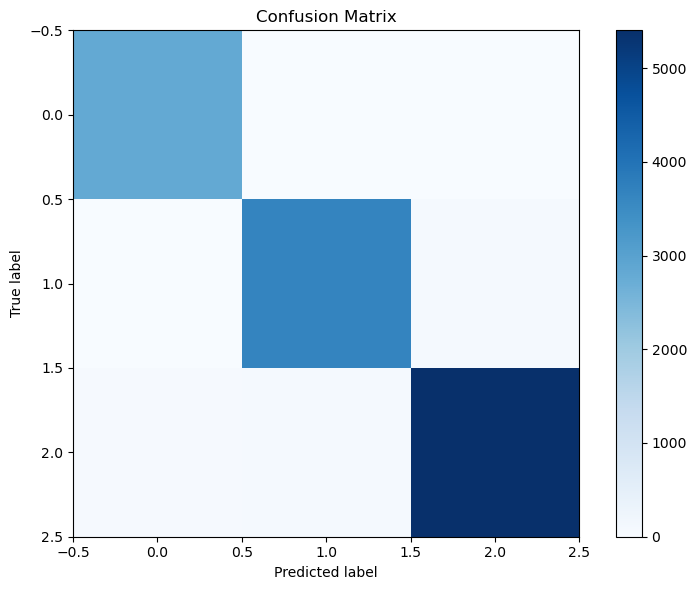

In [15]:
# Classification report
print("Classification Report:")
print(classification_report(valid_y, y_pred, target_names=ClassNames))

# Confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(valid_y, y_pred)
print(conf_mat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Store confusion matrix in variable conf_mat
conf_mat = plt

plt.show()